In [87]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
from tensorflow.keras.layers import Flatten, Conv2D, Conv2DTranspose, BatchNormalization, Reshape, Dense, LeakyReLU

## Download the data

In [1]:
import urllib
categories = [line.rstrip(b'\n') for line in urllib.request.urlopen('https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt')]
print(categories[:10])
category = 'candle'

[b'aircraft carrier', b'airplane', b'alarm clock', b'ambulance', b'angel', b'animal migration', b'ant', b'anvil', b'apple', b'arm']


In [240]:
# Creates a folder to download the original drawings into.
# We chose to use the numpy format : 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]

if not os.path.isdir('npy_files'):
    os.mkdir('npy_files')
    
url = f'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{category}.npy'  
urllib.request.urlretrieve(url, f'npy_files/{category}.npy')

images = np.load(f'npy_files/{category}.npy')
print(f'{len(images)} images to train on')

# You can limit the amount of images you use for training by setting :
train_images = images[:110000]
# You should also define a samller subset of the images for testing..
test_images = images[110000:]
# Notice that this to numpy format contains 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]

141545 images to train on


## Reshape the data

In [241]:
train_images = train_images.reshape(-1, 28,28, 1)
test_images = test_images.reshape(-1, 28,28, 1)

## Normalize the data

In [242]:
def normalize(data):
    normalized_input = (data - np.amin(data)) / (np.amax(data) - np.amin(data))
    return 2*normalized_input - 1

In [243]:
train_images = normalize(train_images)
test_images = normalize(test_images)

In [244]:
test_images.shape

(31545, 28, 28, 1)

In [245]:
train_tfds = tf.data.Dataset.from_tensor_slices(train_images)

test_tfds = tf.data.Dataset.from_tensor_slices(test_images)

## Preprocess the data

In [278]:
def preprocessing(ds):
    ds = ds.map(lambda image: image)
    ds = ds.cache()
    ds = ds.shuffle(10000)
    ds = ds.batch(100)
    ds = ds.prefetch(10)
    return ds

In [279]:
train_ds = train_tfds.apply(preprocessing)
test_ds = test_tfds.apply(preprocessing)

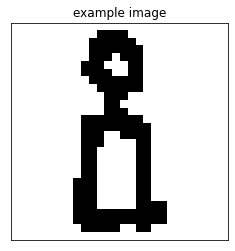

In [248]:
fig, axarr = plt.subplots()
for input in test_ds:
    axarr.set_title("example image")
    axarr.get_xaxis().set_visible(False)
    axarr.get_yaxis().set_visible(False)
    axarr.imshow(tf.squeeze(input)[2].numpy().astype("uint8"), cmap='gray')


## The Discriminator

In [285]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.input_layer = tf.keras.Input(shape=(28,28,1))
        self.layers_ls = [Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding="same", activation=LeakyReLU(alpha=0.01)),
                          BatchNormalization(),
                          Conv2D(16, kernel_size=(3, 3), strides=(2, 2),padding="same", activation=LeakyReLU(alpha=0.01)),
                          BatchNormalization(),
                          Flatten(), 
                          Dense(1, activation="sigmoid")]
                          
        self.out = self.call(self.input_layer)
        
    def call(self, input):
        output = input

        for layer in self.layers_ls:
            output = layer(output, training = True)

        return output

## The Generator

In [293]:
class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()
        self.input_layer = tf.keras.layers.Input(shape=(100))
        
        self.layers_ls = [Dense(7*7*100, activation="relu"),
                          BatchNormalization(),
                          Reshape((7, 7, 100)),
                          Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), padding="same", activation=LeakyReLU(alpha=0.01), use_bias=False, \
                          kernel_regularizer=tf.keras.regularizers.L2(0.2)),
                          BatchNormalization(),
                          Conv2DTranspose(filters=16, kernel_size=(3, 3), strides=(2, 2), padding="same", activation=LeakyReLU(alpha=0.01), \
                          kernel_regularizer=tf.keras.regularizers.L2(0.2)),
                          BatchNormalization(),
                          Conv2D(filters=1, kernel_size=(3, 3), padding="same", activation="tanh", kernel_regularizer=tf.keras.regularizers.L2(0.2))]

        self.out = self.call(self.input_layer)
                          

    def call(self, input):
        output = input
        
        for layer in self.layers_ls:
            output = layer(output, training=True)

        return output


## The GAN

In [287]:
class GAN(tf.keras.Model):
    def __init__(self, loss_function_generator, loss_function_discriminator, optimizer_generator, optimizer_discriminator):
        super(GAN, self).__init__()

        self.discriminator = Discriminator()
        self.generator = Generator()

        self.loss_function_generator = loss_function_generator
        self.optimizer_generator = optimizer_generator

        self.loss_function_discriminator = loss_function_discriminator
        self.optimizer_discriminator = optimizer_discriminator

        self.matching = tf.keras.metrics.BinaryAccuracy()

    @tf.function
    def call(self, input):
        generated_image = self.generator(input)
        output = self.discriminator(generated_image)
        return generated_image, output
    
     
    def train(self, input):
        noise_input =  tf.random.normal(shape=(100, 100))

        with tf.GradientTape() as G_tape, tf.GradientTape() as D_tape:
            fake_data = self.generator(noise_input)
            fake_data_pred = self.discriminator(fake_data)
            real_data_pred = self.discriminator(input)
            
            D_loss = self.loss_function_discriminator(tf.ones_like(real_data_pred), real_data_pred) \
                        + self.loss_function_discriminator(tf.zeros_like(fake_data_pred), fake_data_pred)
             
            G_loss = self.loss_function_generator(tf.ones_like(fake_data_pred), fake_data_pred)
            
            
            D_gradients = D_tape.gradient(D_loss, self.discriminator.trainable_variables)
            self.optimizer_discriminator.apply_gradients(zip(D_gradients, self.discriminator.trainable_variables))

            G_gradients = G_tape.gradient(G_loss, self.generator.trainable_variables)
            self.optimizer_generator.apply_gradients(zip(G_gradients, self.generator.trainable_variables))

        labels = tf.concat((tf.ones_like(real_data_pred), tf.zeros_like(fake_data_pred)), axis=0)
        predictions = tf.concat((real_data_pred, fake_data_pred), axis=0)

        return fake_data, self.matching(labels, predictions)

    def test(self, test_data):
        # aggregator lists for tracking the loss
        test_loss_agg = []
        # iterate over all input-target pairs in test_data
        for input in test_data:
            output = self.discriminator(input)
            prediction_labels = tf.ones_like(output)

            # add loss to aggregators
            test_loss_agg.append(self.matching(output, prediction_labels))

        # calculate mean loss
        test_loss = tf.reduce_mean(test_loss_agg)

        return test_loss

In [316]:
def visualise_images(original_images, epoch = None):
    fig, axarr = plt.subplots()
    axarr.set_title("the generated image")
    axarr.get_xaxis().set_visible(False)
    axarr.get_yaxis().set_visible(False)
    if epoch:
        axarr.imshow(original_images[epoch][0, :, :, 0], cmap='gray')
    else:
        axarr.imshow(original_images, cmap='gray')

    plt.show()

Epoch 0 starting with test-loss of 0.0


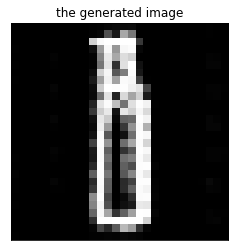

Epoch 1 starting with test-loss of 0.5389999747276306


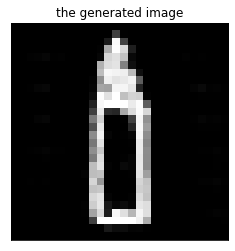

Epoch 2 starting with test-loss of 0.6629999876022339


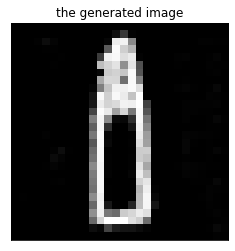

Epoch 3 starting with test-loss of 0.7160000205039978


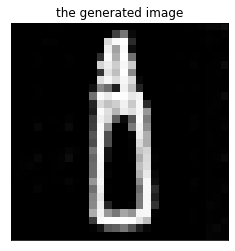

Epoch 4 starting with test-loss of 0.7419999837875366


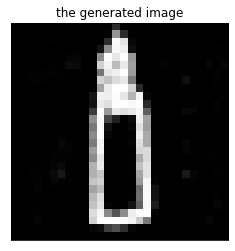

Epoch 5 starting with test-loss of 0.7559999823570251


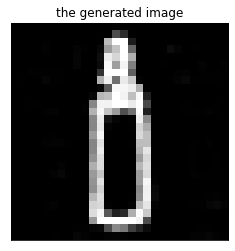

Epoch 6 starting with test-loss of 0.7670000195503235


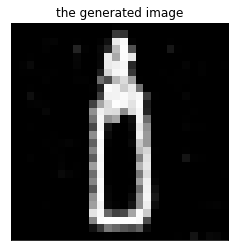

Epoch 7 starting with test-loss of 0.7730000019073486


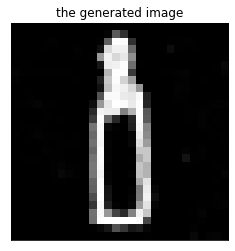

Epoch 8 starting with test-loss of 0.777999997138977


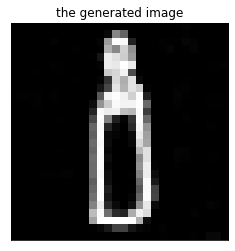

Epoch 9 starting with test-loss of 0.781000018119812


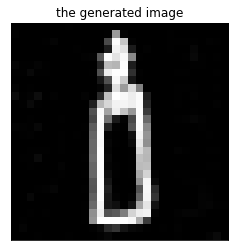

Epoch 10 starting with test-loss of 0.7820000052452087


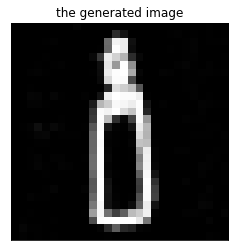

In [297]:
tf.keras.backend.clear_session()

# Setting Hyperparameters
EPOCHS = 10
LEARNING_RATE = 0.001

# Initialize the loss-functions
mse_loss_G = tf.keras.losses.BinaryCrossentropy()
mse_loss_D = tf.keras.losses.BinaryCrossentropy()

# Initialize the optimizers
optimizer_G = tf.keras.optimizers.Adam(LEARNING_RATE)
optimizer_D = tf.keras.optimizers.Adam(LEARNING_RATE)

# Initialize the model
model = GAN(mse_loss_G, mse_loss_D, optimizer_G, optimizer_D)

# Initialize lists for tracking loss
train_losses = []
test_losses = []

# Testing models performance before training starts.
# Test-Dataset
test_loss = model.test(test_ds)
test_losses.append(test_loss)

# Train-Dataset
train_loss = model.test(train_ds)
train_losses.append(train_loss)

generated_images = []

# Training for EPOCHS.
for epoch in range(EPOCHS+1):
    print(f'Epoch {str(epoch)} starting with test-loss of {np.round(test_losses[-1],3)}')
    epoch_loss_agg = []
    for input in train_ds:
        generated_image, train_loss =  model.train(input)
        epoch_loss_agg.append(train_loss) 

    generated_images.append(model(tf.random.normal(shape=(1, 100)))[0])   

    # track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))


    # track loss for test-dataset
    test_loss = model.test(test_ds)
    test_losses.append(test_loss)

    # compare the results 
    visualise_images(generated_images, epoch)


The number shown between the pictures is the discriminator' loss over the test dataset, which shows that the discriminator is giving a high probability for real data, i.e. recognising real data as true.

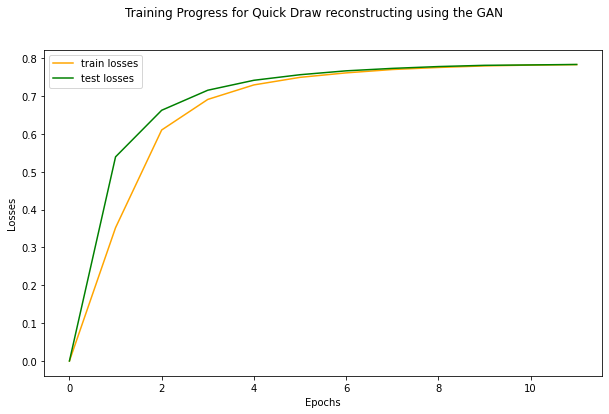

In [298]:
fig, axs = plt.subplots(1, 1)
fig.set_size_inches(10, 6)

fig.suptitle('Training Progress for Quick Draw reconstructing using the GAN')
axs.plot(train_losses, color='orange', label='train losses')
axs.plot(test_losses, color='green', label='test losses')
axs.set(xlabel = 'Epochs', ylabel='Losses')
axs.legend()


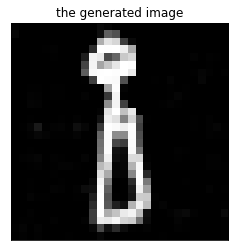

In [336]:
example = tf.random.normal(shape=(5, 100))
output_generator = model.generator(example)[0]

visualise_images(output_generator)

After 10 epochs the generator performs well in generating new samples that are similar to the input dataset.